### Idea for denoising archetecture
0. Option: Add noise during training
1. Add attention on skip connections
2. Larger models need more time to train
3. Old model used average pooling (try max pooling)
4. Replace phase feature with MFCC or another useful feature e.g level * frequency
  a. edge detection


## 1. Using a Laplacian Filter (Edge Detection)
```python
import cv2
import numpy as np

# Apply the Laplacian filter
filtered_spectrogram = cv2.Laplacian(spectrogram, cv2.CV_64F, ksize=3)





And either use MFCC, or Cepstrum

In [1]:
import sys
import os

# Detect Google Colab
if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import librosa
import numpy as np
import h5py
import cv2
from sklearn.preprocessing import StandardScaler

def extract_features(y, sr):
    """
    Extracts audio features from a file and saves them in an HDF5 file.

    Parameters:
    - file_path: Path to the audio file (WAV, MP3, etc.)
    - h5_file_path: Path to the output HDF5 file to save the features.
    """
    # Compute spectrogram using STFT
    spectrogram = librosa.stft(y)

    phase = np.angle(spectrogram)
    magnitude = librosa.amplitude_to_db(np.abs(spectrogram))
    magnitude = magnitude.astype(np.float64)

    # Apply Laplacian filter (Edge detection on spectrogram)
    laplacian_spec = cv2.Laplacian(magnitude, cv2.CV_64F, ksize=9)

    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Compute Delta and Delta-Delta of MFCCs
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)

    data = {
        'phase': phase,
        'spectrogram': magnitude,
        'laplacian_spectrogram': laplacian_spec,
        'mfccs': mfccs,
        'mfcc_delta': mfcc_delta,
        'mfcc_delta2': mfcc_delta2
    }
    return data

# Example usage:
file_path = "/content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100/Jay Menon - Through My Eyes_mixture_sec196.wav"
y, sr = librosa.load(file_path, sr=None)

data = extract_features(y, sr)


In [16]:
import time

start_time = time.perf_counter()
data = extract_features(y, sr)
end_time = time.perf_counter()

print(f"Execution time: {end_time - start_time:.6f} seconds")


Execution time: 0.048931 seconds


In [8]:
import cProfile

profiler = cProfile.Profile()
profiler.enable()

data = extract_features(y, sr)  # Call function with arguments

profiler.disable()
profiler.print_stats()


         1772 function calls (1764 primitive calls) in 0.031 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       24    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1101(_sanity_check)
       24    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1165(_find_and_load)
       24    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1192(_gcd_import)
        1    0.000    0.000    0.031    0.031 <ipython-input-2-ca58c7f06f26>:7(extract_features)
        1    0.000    0.000    0.000    0.000 <ipython-input-8-531c0d29cfd4>:1(<cell line: 0>)
       24    0.000    0.000    0.000    0.000 __init__.py:108(import_module)
    24/22    0.000    0.000    0.000    0.000 __init__.py:77(__getattr__)
        8    0.000    0.000    0.000    0.000 _arraytools.py:7(axis_slice)
        4    0.000    0.000    0.000    0.000 _base.py:1513(issparse)
        2    0.000    0.000    0.000    0.000 _basic.

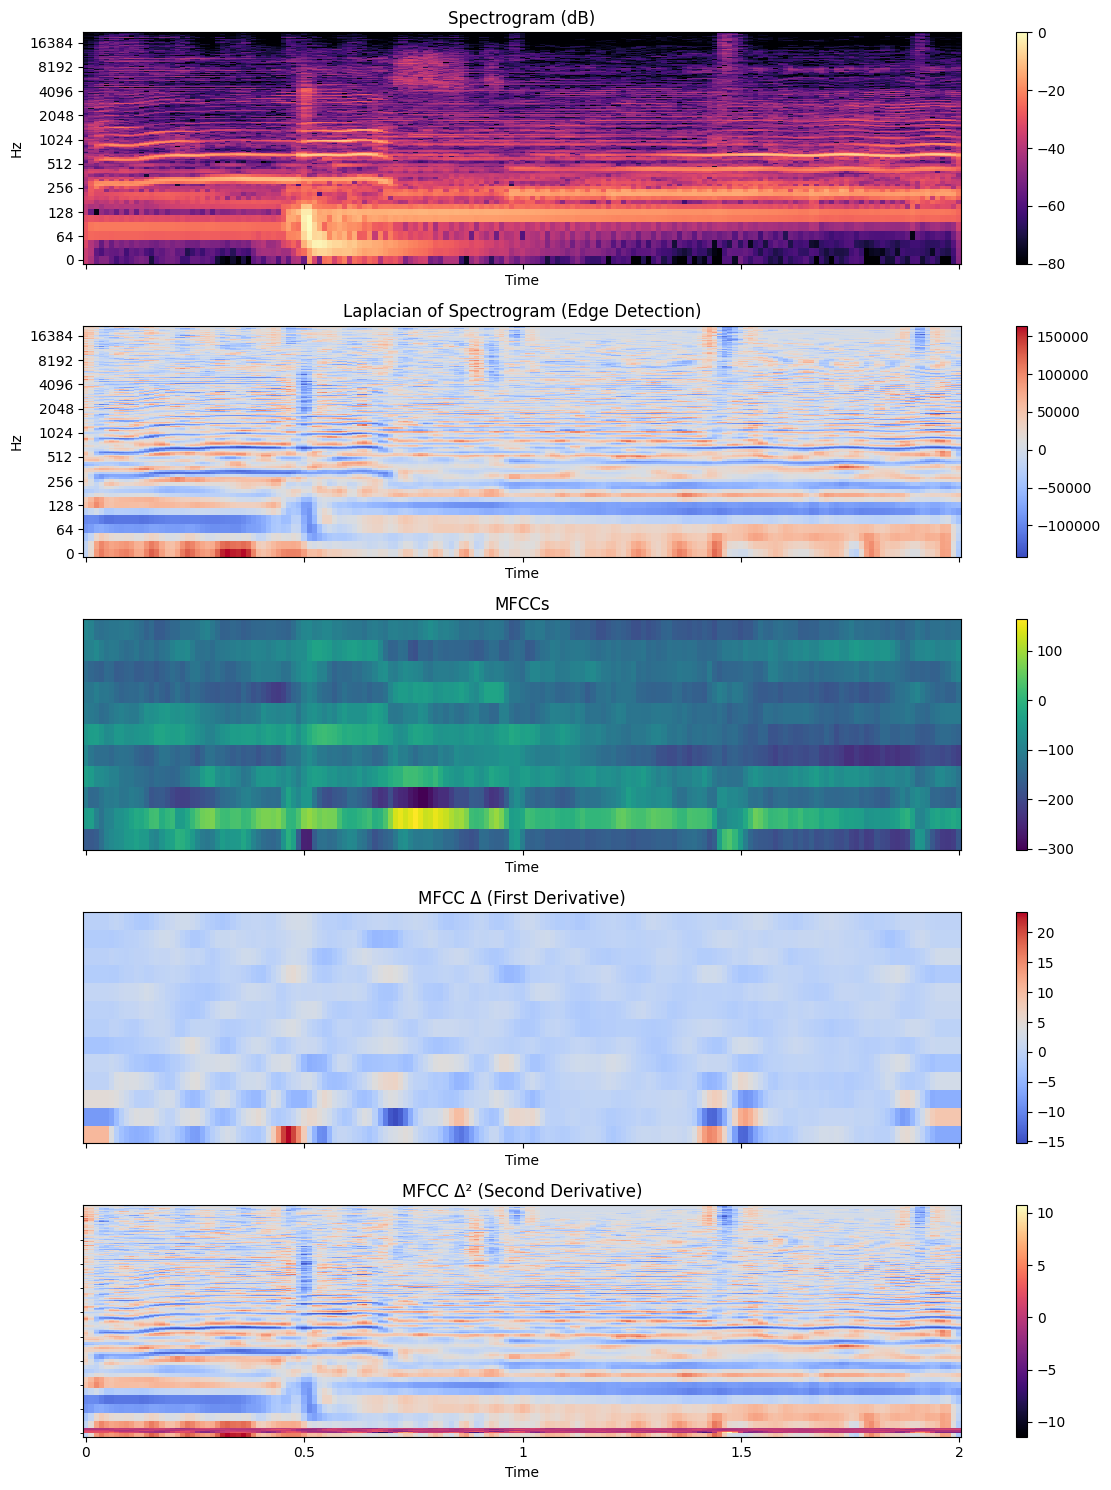

In [5]:
import matplotlib.pyplot as plt
import librosa.display

def plot_features(data, sr):
    """
    Plots spectrogram, Laplacian spectrogram, MFCCs, MFCC deltas, and MFCC delta-deltas.

    Parameters:
    - data: Dictionary containing the extracted features.
    - sr: Sampling rate of the audio.
    """
    fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

    # Spectrogram
    librosa.display.specshow(data['spectrogram'], sr=sr, x_axis="time", y_axis="log", ax=axes[0])
    axes[0].set_title("Spectrogram (dB)")
    fig.colorbar(librosa.display.specshow(data['spectrogram'], sr=sr, x_axis="time", y_axis="log"), ax=axes[0])

    # Laplacian of Spectrogram (Edge Detection)
    librosa.display.specshow(data['laplacian_spectrogram'], sr=sr, x_axis="time", y_axis="log", ax=axes[1], cmap="coolwarm")
    axes[1].set_title("Laplacian of Spectrogram (Edge Detection)")
    fig.colorbar(librosa.display.specshow(data['laplacian_spectrogram'], sr=sr, x_axis="time", y_axis="log", cmap="coolwarm"), ax=axes[1])

    # MFCCs
    librosa.display.specshow(data['mfccs'][2:], x_axis="time", sr=sr, cmap="viridis", ax=axes[2])
    axes[2].set_title("MFCCs")
    fig.colorbar(librosa.display.specshow(data['mfccs'], x_axis="time", sr=sr, cmap="viridis"), ax=axes[2])

    # MFCC Delta
    librosa.display.specshow(data['mfcc_delta'], x_axis="time", sr=sr, cmap="coolwarm", ax=axes[3])
    axes[3].set_title("MFCC Δ (First Derivative)")
    fig.colorbar(librosa.display.specshow(data['mfcc_delta'], x_axis="time", sr=sr, cmap="coolwarm"), ax=axes[3])

    # MFCC Delta-Delta
    librosa.display.specshow(data['mfcc_delta2'], x_axis="time", sr=sr, cmap="magma", ax=axes[4])
    axes[4].set_title("MFCC Δ² (Second Derivative)")
    fig.colorbar(librosa.display.specshow(data['mfcc_delta2'], x_axis="time", sr=sr, cmap="magma"), ax=axes[4])

    plt.tight_layout()
    plt.show()

# Example usage
plot_features(data, sr)


Environmental Sound Classification 50

In [26]:
# Detect Google Colab
if "google.colab" in sys.modules:
    print("Running in Google Colab...")
    os.system("git clone https://github.com/CiaranMaloy/audioautoencoder")
    os.chdir("/content/audioautoencoder/")
    os.system("git pull")
    os.system("git checkout refactor")
    os.system("git pull origin refactor")
    os.system("pip install --upgrade torchmetrics")
else:
    print("Running locally...")
    os.system("git pull origin refactor")
    os.system("pip install --upgrade torchmetrics")


Running in Google Colab...


In [27]:
import sys
sys.path.append('/content/audioautoencoder')
sys.path.append('/content/audioautoencoder/audioautoencoder')

In [28]:
from audioautoencoder.data import *
from audioautoencoder.outputs import *
from audioautoencoder.processing import *
from audioautoencoder.training import *
from audioautoencoder.datasets.loaders import *
from audioautoencoder.generate_dataset import *
from audioautoencoder.plotting import *

test get item input and output to see if i can use the log magnitude and then reverse it on the output

## Data Generation

In [29]:
from audioautoencoder.data_management import *

In [30]:
GENERATE=False

In [31]:
# Example Usage
if GENERATE:
  dataset_dirs = ["/content/drive/MyDrive/Datasets/Noise/All_Noise"]
  output_dir = "/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2"
  splits = create_datasets(dataset_dirs, output_dir)
  print("Training Set:", len(splits["train"]))
  print("Validation Set:", len(splits["val"]))
  print("Testing Set:", len(splits["test"]))


In [32]:
if GENERATE:
  save_splits_to_directories(splits, output_dir, max_workers=8)

In [33]:
# generate audio files for noise and music (2s)
if GENERATE:
  noise_test = output_dir + "/test"
  noise_train = output_dir + "/train"

  noise_test_output = noise_test + "-2s-44100"
  noise_train_output = noise_train + "-2s-44100"

  for input_path, output_path in [(noise_test, noise_test_output), (noise_train, noise_train_output)]:
    print(input_path, output_path)
    generate_audio_files(input_path, output_path, t=2)

In [34]:
# generate audio files for noise and music (2s)
if False:
  music_test = "/content/drive/MyDrive/Datasets/Music/MUSDB18--test/test"
  music_train = "/content/drive/MyDrive/Datasets/Music/MUSDB18--test/train"

  music_test_output = music_test + "-2s-44100"
  music_train_output = music_train + "-2s-44100"

  for input_path, output_path in [(music_test, music_test_output), (music_train, music_train_output)]:
    print(input_path, output_path)
    generate_audio_files(input_path, output_path, t=2)

## Process files to H5

In [35]:
GENERATE_H5_FILES = False
if GENERATE_H5_FILES:
  processor = DatasetProcessor(
          train_music_dir='/content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100',
          train_noise_dir='/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/train-2s-44100',
          test_music_dir='/content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100',
          test_noise_dir='/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/test-2s-44100',
          output_dir='/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep',
          SNRdB=[-10, 10],
          process_train=True,
          process_test=True
      )
  processor.process()

  processor = DatasetProcessor(
          train_music_dir='/content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100',
          train_noise_dir='/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/train-2s-44100',
          test_music_dir='/content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100',
          test_noise_dir='/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/test-2s-44100',
          output_dir='/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep',
          SNRdB=[0, 20],
          process_train=True,
          process_test=True
      )
  processor.process()

  processor = DatasetProcessor(
          train_music_dir='/content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100',
          train_noise_dir='/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/train-2s-44100',
          test_music_dir='/content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100',
          test_noise_dir='/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/test-2s-44100',
          output_dir='/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep',
          SNRdB=[10, 30],
          process_train=True,
          process_test=True
      )
  processor.process()

  processor = DatasetProcessor(
          train_music_dir='/content/drive/MyDrive/Datasets/Music/MUSDB18/train-2s-44100',
          train_noise_dir='/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/train-2s-44100',
          test_music_dir='/content/drive/MyDrive/Datasets/Music/MUSDB18/test-2s-44100',
          test_noise_dir='/content/drive/MyDrive/Datasets/Noise/All_Noise/splits_v2/test-2s-44100',
          output_dir='/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_mix',
          SNRdB=[-10, 30],
          process_train=True,
          process_test=True,
          mix_only=True
      )
  processor.process()

## Define Autoencoder structure

## Improvement to UnetAutoencoder

1. changed padding from explicit to on the output of the convolutional layer
2. added batch normalisation between layers
3. changed fro elu to leaky_relu for efficiency
4. in the other one there is no pooling... and the skip connections are done by concatenation?

#### For v3, remove pooling layers, and add attention onto skip connections

In addition, try only music and only crowd as a dataset

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# too big without.... lets try, halfing the expansion
# apternaitvely use max pooling instead of average pooling
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)  # Avg Pooling
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # Max Pooling
        attn = self.conv(torch.cat([avg_out, max_out], dim=1))  # Convolution
        return x * self.sigmoid(attn)  # Apply Attention Map

class UNetConv5(nn.Module):
    # Update from UnetConv3, stride dimentionality reduction + attention on skip connections
    def __init__(self, in_channels=2, out_channels=1):
        super(UNetConv5, self).__init__()

        a = 2
        A, B, C, D = 64, 128, 256, 512
        bottleneck_channels = 1024

        # Encoder (Downsampling)
        enc_channels = [in_channels, A, B, C, D]
        self.enc1 = self.conv_block(enc_channels[0], enc_channels[1], 7, 1)
        self.enc2 = self.conv_block(enc_channels[1], enc_channels[2], 5, 2)
        self.enc3 = self.conv_block(enc_channels[2], enc_channels[3], 3, 2)
        self.enc4 = self.conv_block(enc_channels[3], enc_channels[4], 3, 2)

        # Bottleneck
        self.bottleneck = self.conv_block(enc_channels[4], bottleneck_channels, 3, 2)

        # Decoder (Upsampling)
        dec_channels = [bottleneck_channels, D, C, B, A]
        self.dec4 = self.upconv_block(dec_channels[0], dec_channels[1], 3, 2)
        self.dec3 = self.upconv_block(dec_channels[1] + enc_channels[4], dec_channels[2], 3, 2)
        self.dec2 = self.upconv_block(dec_channels[2] + enc_channels[3], dec_channels[3], 5, 2)
        self.dec1 = self.upconv_block(dec_channels[3] + enc_channels[2], dec_channels[4], 7, 1)

        # Final Output Layer
        self.final = nn.Conv2d(dec_channels[4] + enc_channels[1], out_channels, kernel_size=3, padding=1, stride=1)

        # Initialize Spatial Attention Modules
        self.spatial_attn4 = SpatialAttention()
        self.spatial_attn3 = SpatialAttention()
        self.spatial_attn2 = SpatialAttention()
        self.spatial_attn1 = SpatialAttention()

    def conv_block(self, in_channels, out_channels, kernel_size, stride, dropout=0.2):
        """Convolutional Block with Dropout in Deeper Layers Only"""
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, stride=stride), # In the next iteration i should introduce a stride here
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        ]

        # Dropout only for deeper encoder layers
        if out_channels >= 256:
            layers.append(nn.Dropout(dropout))

        return nn.Sequential(*layers)

    def upconv_block(self, in_channels, out_channels, kernel_size, stride, dropout=0.2):
        """Upsampling Block with Dropout in First Few Decoder Layers"""
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        ]

        # Dropout only for first few decoder layers
        if in_channels >= 256:
            layers.append(nn.Dropout(dropout))

        return nn.Sequential(*layers)


    def forward(self, x):
        """Forward pass with skip connections"""
        # Encoding
        e1 = self.enc1(x)  # (batch, 64, 1028, 175)
        e2 = self.enc2(e1) # (batch, 128, 514, 87)
        e3 = self.enc3(e2)  # (batch, 256, 257, 43)
        e4 = self.enc4(e3) # (batch, 512, 128, 21)

        # Bottleneck
        b = self.bottleneck(e4)  # (batch, 1024, 64, 10)

        # Decoding + Skip Connections with Spatial Attention
        d4 = self.dec4(b)  # (batch, 512, ?, ?)
        d4 = F.interpolate(d4, size=e4.shape[2:], mode="bilinear", align_corners=False)
        e4_attn = self.spatial_attn4(e4)  # Apply Spatial Attention
        d4 = torch.cat([d4, e4_attn], dim=1)

        d3 = self.dec3(d4)  # (batch, 256, ?, ?)
        d3 = F.interpolate(d3, size=e3.shape[2:], mode="bilinear", align_corners=False)
        e3_attn = self.spatial_attn3(e3)  # Apply Spatial Attention
        d3 = torch.cat([d3, e3_attn], dim=1)

        d2 = self.dec2(d3)  # (batch, 128, ?, ?)
        d2 = F.interpolate(d2, size=e2.shape[2:], mode="bilinear", align_corners=False)
        e2_attn = self.spatial_attn2(e2)  # Apply Spatial Attention
        d2 = torch.cat([d2, e2_attn], dim=1)

        d1 = self.dec1(d2)  # (batch, 64, ?, ?)
        d1 = F.interpolate(d1, size=e1.shape[2:], mode="bilinear", align_corners=False)
        e1_attn = self.spatial_attn1(e1)  # Apply Spatial Attention
        d1 = torch.cat([d1, e1_attn], dim=1)

        # Final Convolution (output denoised spectrogram)
        return F.interpolate(self.final(d1), size=(1025, 175), mode="bilinear", align_corners=False)


In [82]:
BATCH_SIZE = 4

In [84]:
if __name__ == "__main__":
    x = torch.randn((BATCH_SIZE, 2, 1025, 175))
    model = UNetConv5()
    output = model(x)

    print('output....')
    print(output.shape)

output....
torch.Size([4, 1, 1025, 175])


In [85]:
import unittest
import torch
from torchsummary import summary

class TestAutoencoder(unittest.TestCase):
    def setUp(self):
        self.model = UNetConv5()
        self.input_channels = 2
        self.output_channels = 1
        self.input_height = 1025
        self.input_width = 175
        self.batch_size = BATCH_SIZE
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def test_model_initialization(self):
        self.assertIsInstance(self.model, UNetConv5, "Model initialization failed")

    def test_forward_pass(self):
        x = torch.randn(self.batch_size, self.input_channels, self.input_height, self.input_width, device=self.device)
        output = self.model(x)
        self.assertEqual(
            output.shape,
            (self.batch_size, self.output_channels, self.input_height, self.input_width),
            f"Expected output shape {(self.batch_size, self.output_channels, self.input_height, self.input_width)}, but got {output.shape}"
        )

    def test_model_summary(self):
        try:
            summary(self.model, input_size=(self.input_channels, self.input_height, self.input_width))
        except Exception as e:
            self.fail(f"Model summary failed: {str(e)}")

# This allows running tests externally
def suite():
    test_suite = unittest.TestLoader().loadTestsFromTestCase(TestAutoencoder)
    return test_suite

# runner
class TestRunner:
    def __init__(self):
        self.runner = unittest.TextTestRunner()

    def run(self):
        print("Running autoencoder tests...")
        self.runner.run(suite())

if __name__ == "__main__":
    runner = TestRunner()
    runner.run()

Running autoencoder tests...


...
----------------------------------------------------------------------
Ran 3 tests in 0.744s

OK


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 64, 1021, 171]           6,336
       BatchNorm2d-2        [-1, 64, 1021, 171]             128
         LeakyReLU-3        [-1, 64, 1021, 171]               0
            Conv2d-4        [-1, 64, 1017, 167]         200,768
       BatchNorm2d-5        [-1, 64, 1017, 167]             128
         LeakyReLU-6        [-1, 64, 1017, 167]               0
            Conv2d-7         [-1, 128, 508, 83]         204,928
       BatchNorm2d-8         [-1, 128, 508, 83]             256
         LeakyReLU-9         [-1, 128, 508, 83]               0
           Conv2d-10         [-1, 128, 506, 81]         409,728
      BatchNorm2d-11         [-1, 128, 506, 81]             256
        LeakyReLU-12         [-1, 128, 506, 81]               0
           Conv2d-13         [-1, 256, 253, 41]         295,168
      BatchNorm2d-14         [-1, 256, 

## First train as an autoencoder for music

## Download file to local

In [87]:
from audioautoencoder.models.UNetConv4 import UNetConv4

In [40]:
from audioautoencoder.plotting import *
from audioautoencoder.datasets.utils import *

In [95]:
i = 0
train = True

# --------------- Main Execution parameters ---------------
model_name = 'UNetConv4'
SNRdB_load = [0, 20]
SNRdBs = [[0, 20]] # SNR random range
load_trigger = [True]
load_file = 'Autoencodermodel_earlystopping.pth'
#load_file = 'Autoencodermodel_checkpoint.pth'

folder = ['sep'][i] # sep

# parameters
learning_rates = [1e-4] # 1e-4 for re0training?, 1e-3 for training?

base_lr=1e-5
max_lr=learning_rates[i]
gamma=0.8

# data params
max_file_size_gb = 100
IMPORT_TRAIN_NOISY = train
batch_size = 32

# training params
load = load_trigger[i]
warm_start = False
epochs = 100
accumulation_steps = int(512/batch_size)

SNRdB = SNRdBs[i]
learning_rate = learning_rates[i]
eta_min = 1e-6

print('lr:', learning_rate)
print('SNRdB:', SNRdB)

lr: 0.0001
SNRdB: [0, 20]


In [96]:
# --------------- In Loop Parameters --------------
output_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_{model_name}_{SNRdB[0]}-{SNRdB[1]}/'
load_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_{model_name}_{SNRdB_load[0]}-{SNRdB_load[1]}/{load_file}'

In [97]:
# Define the source and destination file paths
source_folder = f"/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_{folder}/SNRdB_{SNRdB[0]}-{SNRdB[1]}/"
source_path = source_folder + "train/"
destination_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/"
save_path = source_folder + "combined_000.h5"

if IMPORT_TRAIN_NOISY:
  if not os.path.exists(destination_path):
    combine_h5_files(source_path, destination_path, max_file_size_gb=max_file_size_gb)

  train_loader = NoisyDatasetLoader(
        dataset_path=f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/combined_000.h5",
        output_time_length=175,
        channels=1,
        snr_db=SNRdB,
        subset=False,
        batch_size=batch_size
    )

  print(f"Training set size: {len(train_loader.train_dataset)}")
  print(f"Validation set size: {len(train_loader.val_dataset)}")

Input dataset shape: (37316, 2, 1025, 175)
Target dataset shape: (37316, 2, 1025, 175)
Training set size: 29852
Validation set size: 7464
Training set size: 29852
Validation set size: 7464


# Retrain Model

In [98]:
from audioautoencoder.loss import *
from audioautoencoder.utils import *

In [99]:
import torch

torch.cuda.empty_cache()

In [100]:
# Instantiate the model, define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetConv4().to(device)

print(device)

cuda


In [101]:
if load:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=eta_min)
  scheduler_loss = False
else:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=eta_min)
  scheduler_loss = False

  #optimizer = None #torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  #scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
  #scheduler_loss = False #True

Loading model from: /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_UNetConv4_0-20/Autoencodermodel_earlystopping.pth


/content/audioautoencoder/audioautoencoder/training.py:412: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.load_path, map_location=self.device)


Checkpoint keys: dict_keys(['model_state_dict', 'entire_model', 'optimizer_state_dict', 'epoch', 'total_epochs', 'loss'])
Loss: 48.37969984486699, Epoch: 28, Total epochs: 100
Training on device: cuda
Epoch 1, Current Learning Rate: [0.0001]


Training:   0%|          | 0/933 [00:00<?, ?batch/s]

New kl loss beta: 0.0
Noise Level:  0.05


Validating: 100%|██████████| 234/234 [02:50<00:00,  1.38batch/s, loss=joint loss: 0.0568]


--------------------------------------------------
Epoch 1, Validation Loss: 0.0568
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_UNetConv4_0-20/Autoencodermodel_earlystopping.pth.
Saved to Drive...


/content/audioautoencoder/audioautoencoder/training.py:92: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim((b, a))


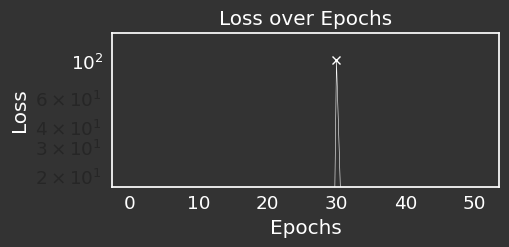

Epoch [1/100], Loss: 0.0532
--------------------------------------------------
Epoch 2, Current Learning Rate: [9.757729755661011e-05]


Training:   0%|          | 0/933 [00:00<?, ?batch/s]

New kl loss beta: 0.01
Noise Level:  0.0475


Validating: 100%|██████████| 234/234 [02:49<00:00,  1.38batch/s, loss=joint loss: 0.0574]


--------------------------------------------------
Epoch 2, Validation Loss: 0.0574
EarlyStopping counter: 1 out of 100
Saved to Drive...


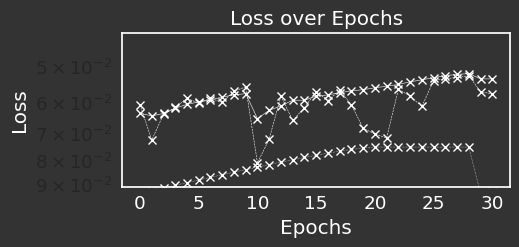

Epoch [2/100], Loss: 0.0532
--------------------------------------------------
Epoch 3, Current Learning Rate: [9.05463412215599e-05]


Training:   0%|          | 0/933 [00:00<?, ?batch/s]

New kl loss beta: 0.02
Noise Level:  0.045000000000000005


Validating: 100%|██████████| 234/234 [02:39<00:00,  1.47batch/s, loss=joint loss: 0.0566]


--------------------------------------------------
Epoch 3, Validation Loss: 0.0566
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_UNetConv4_0-20/Autoencodermodel_earlystopping.pth.
Saved to Drive...


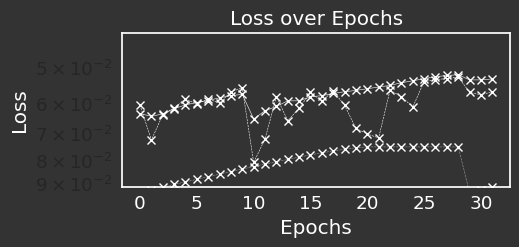

Epoch [3/100], Loss: 0.0530
--------------------------------------------------
Epoch 4, Current Learning Rate: [7.959536998847742e-05]


Training:   0%|          | 0/933 [00:00<?, ?batch/s]

New kl loss beta: 0.03
Noise Level:  0.0425


Validating: 100%|██████████| 234/234 [02:40<00:00,  1.45batch/s, loss=joint loss: 0.0555]


--------------------------------------------------
Epoch 4, Validation Loss: 0.0555
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_UNetConv4_0-20/Autoencodermodel_earlystopping.pth.
Saved to Drive...


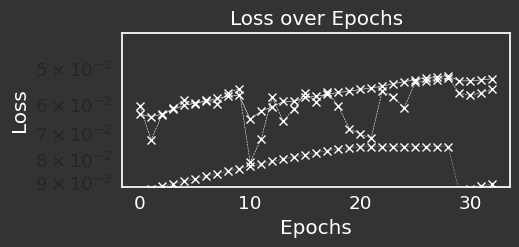

Epoch [4/100], Loss: 0.0527
--------------------------------------------------
Epoch 5, Current Learning Rate: [6.57963412215599e-05]


Training:   0%|          | 0/933 [00:00<?, ?batch/s]

New kl loss beta: 0.04
Noise Level:  0.04000000000000001


Validating: 100%|██████████| 234/234 [02:37<00:00,  1.48batch/s, loss=joint loss: 0.0545]


--------------------------------------------------
Epoch 5, Validation Loss: 0.0545
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_UNetConv4_0-20/Autoencodermodel_earlystopping.pth.
Saved to Drive...


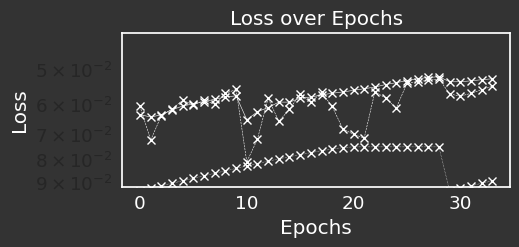

Epoch [5/100], Loss: 0.0524
--------------------------------------------------
Epoch 6, Current Learning Rate: [5.05e-05]


Training:   0%|          | 0/933 [00:00<?, ?batch/s]

New kl loss beta: 0.05
Noise Level:  0.037500000000000006


Validating: 100%|██████████| 234/234 [02:38<00:00,  1.48batch/s, loss=joint loss: 0.0541]


--------------------------------------------------
Epoch 6, Validation Loss: 0.0541
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Denoising/Checkpoints_UNetConv4_0-20/Autoencodermodel_earlystopping.pth.
Saved to Drive...


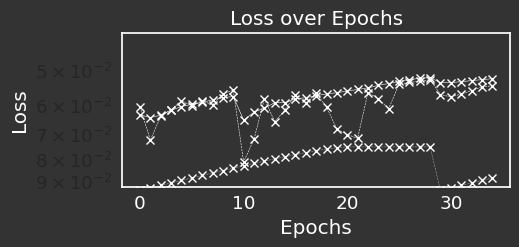

Epoch [6/100], Loss: 0.0522
--------------------------------------------------
Epoch 7, Current Learning Rate: [3.5203658778440106e-05]


Training:   0%|          | 0/933 [00:00<?, ?batch/s]

New kl loss beta: 0.06
Noise Level:  0.034999999999999996


Training:  12%|█▏        | 111/933 [01:28<10:53,  1.26batch/s, loss=loss: 0.0521, ref:0.0881]


KeyboardInterrupt: 

In [102]:
if train:
  trainer = DenoisingTrainer(
      model=model, noisy_train_loader=train_loader.train_loader, noisy_val_loader=train_loader.val_loader,
      SNRdB=SNRdB, output_path=output_path, epochs=epochs, learning_rate=learning_rate,
      load=load, warm_start=warm_start, train=train, verbose=False, accumulation_steps=accumulation_steps, load_path=load_path,
      base_lr=base_lr, max_lr=max_lr, gamma=gamma, optimizer=optimizer, scheduler=scheduler, scheduler_loss=scheduler_loss
  )
  trainer.train_or_evaluate()
  model = trainer.get_model()

  # I need a flat load model function somewhere, as now I need to define a train loader before I can load a model
  csv_file_path = output_path + "training_log.csv"
  plot_training_log(csv_file_path)

## Testing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetConv5().to(device)
denoiser = DenoisingLoader(model, load_path)
model = denoiser.model
print('Loaded Model')

# Example input (batch_size=1, channels=2, height=1025, width=175)
noisy_input = torch.randn(1, 2, 1025, 175)

denoised_output = denoiser.denoise(noisy_input)
print(denoised_output.shape)

## Testing:

In [ ]:
# Define the source and destination file paths
SNRdB = SNRdB # SNR random range
print(SNRdB)
#filename = f"train-SNRdB_{SNRdB}-1s-44-1khz-magnitude-freqweightmagnitude-phase.h5"
source_folder = f"/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_sep/SNRdB_{SNRdB[0]}-{SNRdB[1]}/"
source_path = source_folder + "test/"
destination_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/test/"

save_path = source_folder + "combined_000.h5"

In [ ]:
IMPORT_TEST_NOISY = True
load_dataframe = False

In [ ]:
max_file_size_gb = 30

In [ ]:
destination_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/test/"

if IMPORT_TEST_NOISY:
  if not os.path.exists(destination_path):
    combine_h5_files(source_path, destination_path, max_file_size_gb=max_file_size_gb)

View Pretrained Model Performance

In [ ]:
# checking file contents
file = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/test/combined_000.h5"

# Path to the HDF5 file
h5_file_path = file
n = 50
try:
    # Open the HDF5 file
    with h5py.File(h5_file_path, "r") as h5f:
        # Load 5 instances from the training and testing datasets
        input_images = h5f["input_images"][n:n+5]  # First 5 instances
        target_images = h5f["target_images"][n:n+5]  # First 5 instances
        filenames = h5f["filenames"][n:n+5]
        snr_db = h5f["snr_db"][n:n+5]

        # Convert to NumPy arrays (if not already)
        input_images = np.array(input_images)
        target_images = np.array(target_images)
        filenames = np.array(filenames)
        snr_db = np.array(snr_db)

        print("Loaded 5 training/testing instances:")
        print("Input dataset shape:", input_images.shape)
        print("Target dataset shape:", target_images.shape)

        print(filenames[0:3])
        print(snr_db[0:3])

except Exception as e:
    print("Error reading HDF5 file:", e)

In [ ]:
from audioautoencoder.datasets.utils import *

In [ ]:
if IMPORT_TEST_NOISY:
    test_loader = NoisyDatasetLoader(
        dataset_path=f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/test/combined_000.h5",
        output_time_length=175,
        channels=1,
        snr_db=SNRdB,
        subset=False,
        batch_size=32,
        metadata=True
    )

    print(f"Training set size: {len(test_loader.train_dataset)}")
    print(f"Validation set size: {len(test_loader.val_dataset)}")

In [ ]:
!git pull

In [ ]:
from audioautoencoder.testing import *

In [ ]:
import torch
from tqdm import tqdm
from loss import *

# Testing loop
def test_model(model, test_loader, criterion):
    evaluation = Evaluation()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        progress_bar = tqdm(test_loader, desc="Testing", unit="batch")
        for inputs, targets, metadata in progress_bar:

          inputs, targets = inputs.to(device), targets.to(device)

          outputs = model(inputs)
          loss = criterion(outputs, targets)
          progress_bar.set_postfix(loss=f"{loss.item():.4f}")
          test_loss += loss.item()

          # evaluation
          evaluation.evaluate(inputs, targets, outputs, metadata)

        test_loss /= len(test_loader)

    return test_loss, evaluation.process()

import torch
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
from torchmetrics.audio import SignalDistortionRatio

class Evaluation:
    def __init__(self, device="cuda" if torch.cuda.is_available() else "cpu"):
        """Initialize storage for evaluation metrics."""
        self.results = []
        self.device = torch.device(device)  # Store the device
        self.sdr = SignalDistortionRatio().to(self.device)  # Move SDR metric to the device

    def evaluate(self, inputs, targets, outputs, metadata):
        """
        Compute SDR and L1 loss for input vs. target and input vs. output.
        """
        batch_size = inputs.shape[0]
        chunk_length = 44100 * 2

        for i in range(batch_size):
            filename = metadata[i]["filename"]
            snr_db = metadata[i]["snr_db"]

            input = inputs[i].detach().cpu().numpy()
            target = targets[i].detach().cpu().numpy()
            output = outputs[i].detach().cpu().numpy()

            input_chunk = magphase_to_waveform(input[0], input[1], chunk_length)
            output_chunk = magphase_to_waveform(output[0], input[1], chunk_length)
            target_chunk = magphase_to_waveform(target[0], input[1], chunk_length)

            # Move tensors to the correct device
            input_chunk = torch.from_numpy(input_chunk).to(self.device).float()
            output_chunk = torch.from_numpy(output_chunk).to(self.device).float()
            target_chunk = torch.from_numpy(target_chunk).to(self.device).float()

            input = torch.from_numpy(input).to(self.device).float()
            output = torch.from_numpy(output).to(self.device).float()
            target = torch.from_numpy(target).to(self.device).float()

            # Compute SDR (using torchaudio)
            sdr_invstar = self.sdr(input_chunk, target_chunk).item()
            sdr_outvstar = self.sdr(output_chunk, target_chunk).item()

            # Compute L1 loss
            l1_invstar = F.l1_loss(input[0:1, :, :], target[0:1, :, :]).item()
            l1_outvstar = F.l1_loss(output[0:1, :, :], target[0:1, :, :]).item()

            # Store results
            self.results.append({
                "instance": len(self.results),
                "sdr_invstar": sdr_invstar,
                "sdr_outvstar": sdr_outvstar,
                "l1_invstar": l1_invstar,
                "l1_outvstar": l1_outvstar,
                "filename": filename,
                "snr_db": snr_db,
            })

    def process(self):
        """Return the stored evaluation results as a Pandas DataFrame."""
        return pd.DataFrame(self.results)

In [ ]:
if load_dataframe:
  df_subset = pd.read_csv(output_path + f"df_subset_SNRdB_{SNRdB[0]}-{SNRdB[1]}.csv")

In [ ]:
if not load_dataframe:
  criterion = nn.L1Loss()
  loss, df_eval = test_model(model, test_loader.train_loader, criterion)

In [ ]:
if not load_dataframe:
  # Assuming `df` is your original dataframe
  df_eval["Improvement"] = df_eval["sdr_outvstar"] - df_eval["sdr_invstar"]  # Higher SDR is better
  subset_columns = ["instance", "sdr_invstar", "sdr_outvstar", "l1_invstar", "l1_outvstar", "filename", "snr_db", "Improvement"]
  df_subset = df_eval[subset_columns]

In [ ]:
if not load_dataframe:
  # Create a function to map filename to a class
  def get_class_from_filename(filename, classes):
      for keyword in classes:
          if keyword in filename:
              return keyword
      return 'Unknown'  # Default if no match found

  df_subset[['filename_audio', 'filename_noise']] = pd.DataFrame(df_subset['filename'].tolist(), index=df_subset.index)
  df_subset['filename_audio'] = df_subset['filename_audio'].apply(lambda x: x.decode('utf-8'))
  df_subset['filename_noise'] = df_subset['filename_noise'].apply(lambda x: x.decode('utf-8'))

  classes = ['mixture', 'vocals', 'drums', 'guitar', 'bass', 'piano', 'electric_guitar', 'acoustic_guitar', 'synthesizer', 'strings', 'brass']
  df_subset['audio_class'] = df_subset['filename_audio'].apply(lambda x: get_class_from_filename(x, classes))

  classes = ['0707', 'Rain', 'Crowd', 'Water', 'Ice']
  df_subset['noise_class'] = df_subset['filename_noise'].apply(lambda x: get_class_from_filename(x, classes))


In [ ]:
df_subset["Improvement_L1"] = df_subset["l1_invstar"] - df_subset["l1_outvstar"]  # Lower L1 loss is better

In [ ]:
df_subset.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set minimal theme
sns.set_theme(style="white", font_scale=1.2)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df_subset

# Create a grouped boxplot
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="noise_class", y="Improvement", hue="audio_class", data=df)

# Customize the gridlines
for line in ax.get_ygridlines():
    if line.get_ydata()[0] == 0:  # Check if it's the gridline at y=0
        line.set_color('grey')  # Set color to black
        line.set_linewidth(2)  # Set line width to make it bolder

# Customize plot
plt.title(f"Improvement by Noise Class and Audio Class: SNRdB {SNRdB[0]} to {SNRdB[1]}")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Audio Class", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.grid()
plt.savefig(output_path + f"boxplot_all.png")
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Filter for 'crowd' noise class
df_crowd = df_subset[df_subset["noise_class"] == "Crowd"].copy()

# Create a grouped boxplot
plt.figure(figsize=(7, 5))
ax = sns.boxplot(x="audio_class", y="Improvement", hue="audio_class", data=df_crowd)

# Customize the gridlines
for line in ax.get_ygridlines():
    if line.get_ydata()[0] == 0:  # Check if it's the gridline at y=0
        line.set_color('grey')  # Set color to black
        line.set_linewidth(2)  # Set line width to make it bolder

# Customize plot
plt.title(f"Improvement by Noise Class and Audio Class: SNRdB {SNRdB[0]} to {SNRdB[1]}")
plt.xticks()
#plt.legend(title="Audio Class", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.grid()
plt.savefig(output_path + f"boxplot_crowd.png")
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_eval = df_subset

# Round SNR values to the nearest 0.5 to reduce noise
df_eval["snr_db_rounded"] = df_eval["snr_db"].round(1)  # Rounds to 1 decimal place
df_eval["snr_db_rounded"] = (df_eval["snr_db_rounded"] * 2).round() / 2  # Ensures nearest 0.5

# Group by rounded SNR and audio/noise class, then compute mean improvement
df_audio_avg = df_eval.groupby(["snr_db_rounded", "audio_class"], as_index=False)["Improvement"].mean()
df_noise_avg = df_eval.groupby(["snr_db_rounded", "noise_class"], as_index=False)["Improvement"].mean()

# Line plot colored by 'audio_class'
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_audio_avg, x="snr_db_rounded", y="Improvement", hue="audio_class", palette="tab10", marker="o")
plt.xlabel("SNR (dB)")
plt.ylabel("Mean Improvement (SDR)")
plt.title("Mean Improvement vs SNR (Rounded to 0.5, Colored by Audio Class)")
plt.legend(title="Audio Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()

# Line plot colored by 'noise_class'
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_noise_avg, x="snr_db_rounded", y="Improvement", hue="noise_class", palette="tab10", marker="o")
plt.xlabel("SNR (dB)")
plt.ylabel("Mean Improvement (SDR)")
plt.title("Mean Improvement vs SNR (Rounded to 0.5, Colored by Noise Class)")
plt.legend(title="Noise Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_eval = df_subset

# Round SNR values to the nearest 0.5 to reduce noise
df_eval["snr_db_rounded"] = df_eval["snr_db"].round(1)  # Rounds to 1 decimal place
df_eval["snr_db_rounded"] = (df_eval["snr_db_rounded"] * 2).round() / 2  # Ensures nearest 0.5

# Group by rounded SNR and audio/noise class, then compute mean improvement
df_audio_avg = df_eval.groupby(["snr_db_rounded", "audio_class"], as_index=False)["Improvement_L1"].mean()
df_noise_avg = df_eval.groupby(["snr_db_rounded", "noise_class"], as_index=False)["Improvement_L1"].mean()

# Line plot colored by 'audio_class'
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_audio_avg, x="snr_db_rounded", y="Improvement_L1", hue="audio_class", palette="tab10", marker="o")
plt.xlabel("SNR (dB)")
plt.ylabel("Mean Improvement (SDR)")
plt.title("Mean Improvement vs SNR (Rounded to 0.5, Colored by Audio Class)")
plt.legend(title="Audio Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()

# Line plot colored by 'noise_class'
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_noise_avg, x="snr_db_rounded", y="Improvement_L1", hue="noise_class", palette="tab10", marker="o")
plt.xlabel("SNR (dB)")
plt.ylabel("Mean Improvement (SDR)")
plt.title("Mean Improvement vs SNR (Rounded to 0.5, Colored by Noise Class)")
plt.legend(title="Noise Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df_subset

# Create a grouped boxplot
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="noise_class", y="Improvement_L1", hue="audio_class", data=df)

# Customize the gridlines
for line in ax.get_ygridlines():
    if line.get_ydata()[0] == 0:  # Check if it's the gridline at y=0
        line.set_color('grey')  # Set color to black
        line.set_linewidth(2)  # Set line width to make it bolder

# Customize plot
plt.title(f"Improvement by Noise Class and Audio Class: SNRdB {SNRdB[0]} to {SNRdB[1]}")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Audio Class", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.grid()
plt.savefig(output_path + f"boxplot_all_L1.png")
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Filter for 'crowd' noise class
df_crowd = df_subset[df_subset["noise_class"] == "Crowd"].copy()

# Create a grouped boxplot
plt.figure(figsize=(7, 5))
ax = sns.boxplot(x="audio_class", y="Improvement_L1", hue="audio_class", data=df_crowd)

# Customize the gridlines
for line in ax.get_ygridlines():
    if line.get_ydata()[0] == 0:  # Check if it's the gridline at y=0
        line.set_color('grey')  # Set color to black
        line.set_linewidth(2)  # Set line width to make it bolder

# Customize plot
plt.title(f"Improvement by Noise Class and Audio Class: SNRdB {SNRdB[0]} to {SNRdB[1]}")
plt.xticks()
#plt.legend(title="Audio Class", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.grid()
plt.savefig(output_path + f"boxplot_crowd_L1.png")
plt.show()


In [ ]:
import pandas as pd

# Assuming you already have the dataframe loaded in `df`
# df = pd.read_csv('your_data.csv')  # Uncomment if loading from CSV
df = df_subset

# You can also add visualization here if you want to dive deeper
import seaborn as sns
import matplotlib.pyplot as plt

# Define a more interpretable colormap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['sdr_invstar', 'sdr_outvstar', 'l1_invstar', 'l1_outvstar', 'snr_db', 'Improvement']].corr(),
            annot=True, cmap='mako', fmt=".2f", vmin=-1, vmax=1, center=0)

plt.title("Correlation Matrix")
plt.show()


In [ ]:
# Save subset dataframe
df_subset.to_csv(output_path + f"df_subset_SNRdB_{SNRdB[0]}-{SNRdB[1]}.csv", index=False)

In [ ]:
import soundfile as sf

# Filter the dataframe for rows where Improvement is greater than 3
filtered_df = df_eval[df_eval["Improvement"] > 3]

# Define the maximum number of files to write
max_files = 5

def norm(x):
  # If x is a tensor, convert it to numpy array first
  if isinstance(x, torch.Tensor):
      x = x.detach().cpu().numpy()
  return x / np.max(np.abs(x))

# Loop through the filtered rows and save the chunks to WAV files, but stop at max_files
file_count = 0
for index, row in filtered_df.iterrows():
    if file_count >= max_files:
        break  # Stop if we have written the maximum number of files

    input_chunk = row["input_chunk"]
    output_chunk = row["output_chunk"]
    target_chunk = row["target_chunk"]

    # Write to WAV files
    input_filename = f"/content/input_chunk_{index}.wav"
    output_filename = f"/content/output_chunk_{index}.wav"
    target_filename = f"/content/target_chunk_{index}.wav"

    sf.write(input_filename, norm(input_chunk), 44100)  # Assuming a sample rate of 44100 Hz
    sf.write(output_filename, norm(output_chunk), 44100)
    sf.write(target_filename, norm(target_chunk), 44100)

    # Increment the file count
    file_count += 1

# Print how many files were written
print(f"Total WAV files written: {file_count}")


# Improvements that need to be made

1. Metadata h5 column, including
- Filename
- SNR

## Convert some entire songs and test some metrics

In [ ]:
import os

whole_files = '/content/drive/MyDrive/Datasets/Music/MUSDB18/test/'
song_files = []

# Walk through the directory tree
for root, dirs, files in os.walk(whole_files):
    # Filter files with '.wav' extension and 'mixture' in their name
    for f in files:
        if f.endswith('.wav') and 'mixture' in f:
            full_path = os.path.join(root, f)
            song_files.append(full_path)

print(f"\nTotal matching files: {len(song_files)}")

Generate Audio

In [ ]:
noise_file = '/content/drive/MyDrive/Datasets/Noise/All_Noise/splits/val/Crowd Noise (1)_zkChMb.wav'

In [ ]:
from audioautoencoder.denoising import *

In [ ]:
noisy_audio, sr = generate_audio_with_noise(song_files[0], noise_file, start_time=10, duration=10)

now the answer is to digest this waveform at 1s at a time, process those seconds, at intervals of 0.5s, window the outputs and put it back together for display on spectrograms and/or for output to .wav file

In [ ]:
denoiser = AudioDenoiser(model, output_path=output_path, chunk_duration=2, step_size=0.5)
reconstructed_audio, reconstructed_input = denoiser.process_audio(noisy_audio, sr)

In [ ]:
!pip install mir_eval

Use the SDR metric to compare signal to noise ratios of the generated output, and the standard output and demonstrate an increase in signal to noise ratio overall

In [ ]:
average_rec = np.log(np.average(Pxx_rec, axis=1))
average_spec = np.log(np.average(Pxx_spec, axis=1))

plt.plot(average_rec)
plt.plot(average_spec)
plt.xscale('log')
plt.show()

import numpy as np
import mir_eval

def compute_sdr(reference, estimated):
    """
    Compute the Signal-to-Distortion Ratio (SDR) between reference and estimated signals.

    :param reference: np.ndarray of shape (channels, samples), ground-truth clean signal
    :param estimated: np.ndarray of shape (channels, samples), predicted separated signal
    :return: float, SDR value in dB
    """
    # Ensure inputs are 2D (stereo/multichannel) or 1D (mono)
    reference = np.atleast_2d(reference)
    estimated = np.atleast_2d(estimated)

    # Compute SDR using mir_eval
    sdr, _, _, _ = mir_eval.separation.bss_eval_sources(reference, estimated, compute_permutation=False)

    return np.mean(sdr)  # Return average SDR across channels

# Example usage
if __name__ == "__main__":
    # Fake reference and estimated signals (replace with actual signals)
    ref_signal = reconstructed_audio_input  # 2 channels, 1 second at 44.1kHz
    est_signal = reconstructed_audio  # Slightly noisy estimate

    # max sdr
    sdr_max = compute_sdr(audio, audio)
    print(f"SDR - : {sdr_max:.2f} dB -- Max")

    # reference sdr
    sdr_ref = compute_sdr(audio, noisy_audio)
    print(f"SDR - : {sdr_ref:.2f} dB -- Reference")

    # computed srd
    sdr_value = compute_sdr(audio, est_signal)
    print(f"SDR - : {sdr_value:.2f} dB -- Denoising")
